#**> Goal : 와인의 점수를 예측하는 ML Model 구상**
---

*   **배경**  
    코로나의 여파로 혼술/홈파티족이 생겨나면서, 와인 입문자가 증가하는 추세이다  
    이들에게 와인 선정에 있어서 와인 평가 점수라는 것은 중요한 척도로 작용 할 것이다.  

## **Step 1. Data Preprocessing**

### **1-1. 데이터 업로드**

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyewonson","key":"9868d155f9b32456cf90c8964b1f7782"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

# 캐글 데이터셋 리스트 확인
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-28 17:13:57           3816  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2219  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            474  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1410  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [4]:
# 파일 API 등록
! kaggle datasets download -d rajyellow46/wine-quality

  0% 0.00/98.0k [00:00<?, ?B/s]
100% 98.0k/98.0k [00:00<00:00, 34.1MB/s]


In [5]:
# 파일 압축 해제
!unzip wine-quality.zip

Archive:  wine-quality.zip
  inflating: winequalityN.csv        


In [6]:
import pandas as pd

full_df = pd.read_csv("./winequalityN.csv")

In [7]:
print(full_df.dtypes)
full_df

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### **1-2. 결측치 및 중복 데이터 처리**
결측치 처리 방법은 여러 가지가 있지만,  
결측치가 있는 feature의 특성을 파악해 방향성을 선택하는 것이 무엇보다도 중요하다.

1. **fixed acidity**  결합산 : 와인의 산도를 제어
2. **volatile acidity**  휘발산 : 와인의 향에 연관
3.   **citric acid**  구연산 :  와인의 신선함을 올려주는 역할, 산성화에 연관을 미침
4.  **residual sugar**  잔여 설탕 : 와인에 단맛을 올려줌
5. **chlorides**  염화물 : 와인의 신맛을 담당
6.  **free sulfur dioxide**  유리 화항
7.  **total sulfur dioxide**  총 이산화항 : 와인을 오래 보관하는 역할
8.  **density**  밀도 : 바디의 높고 낮음을 표현하는 와인의 무게감을 의미
9.  **pH**  산성도 : 와인의 신맛의 정도를 나타냄
10. **sulphates**  황산염
11.  **alcohol**  알코올 : 와인의 바디감에 영향
12.  **quality (score between 0 and 10)**  와인 품질

#### **1-2-1. 결측치 처리**
결측치 대체에 있어서 outlier가 존재할 수 있으므로, 이를 확인하여 중앙값으로 대체하고자 한다

#####**1) 결측치 확인**

In [8]:
full_df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

많은 양의 결측치가 아님을 확인할 수 있다.  
하지만 와인의 `type(white/red)`에 결측 내용이 달라짐을 주의해야 한다.

In [9]:
full_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


**1-1) 결측치 확인 example_1**

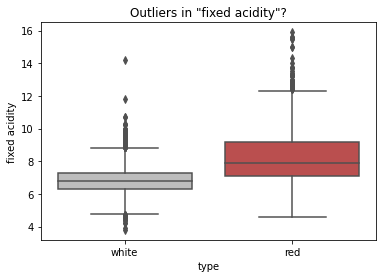

In [10]:
# 'fixed acidity' outlier 확인
from matplotlib import pyplot as plt
import seaborn as sns

# 색 지정
colors = ["#BDBDBD", "#CC3D3D"]
sns.set_palette(sns.color_palette(colors))

sns.boxplot(data=full_df, x='type', y='fixed acidity')
plt.title('Outliers in "fixed acidity"?')
plt.show()

**1-2) 결측치 확인 example_2**

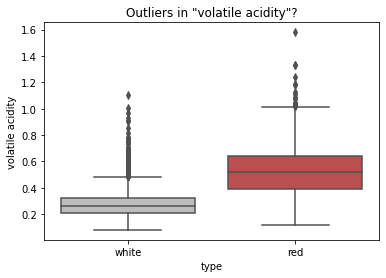

In [11]:
# 'volatile acidity' outlier 확인
# 색 지정
colors = ["#BDBDBD", "#CC3D3D"]
sns.set_palette(sns.color_palette(colors))

sns.boxplot(data=full_df, x='type', y='volatile acidity')
plt.title('Outliers in "volatile acidity"?')
plt.show()

df.describe()를 살펴봤을 때, 중앙값과 평균에 차이가 거의 없으므로 outlier가 없거나 존재해도 큰 격차가 아님을 알 수 있다  
이를 시각적으로 확인하기 위해 결측치가 존재하는 몇몇 feature들을 확인해 본 결과, outlier를 확인할 수 있으나 큰 격차의 outlier는 아니다!  
이에 단위 일치를 위해 중앙값으로 결측치를 대체한다

#####**2) 결측치 처리**

In [12]:
# type에 따른 pH 중앙값 확인
missing_list = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides','pH',  'sulphates']
full_df.groupby(['type'])[missing_list].median()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,pH,sulphates
type,,,,,,,
red,7.9,0.52,0.26,2.2,0.079,3.31,0.62
white,6.8,0.26,0.32,5.2,0.043,3.18,0.47


In [13]:
# 결측치를 중앙값으로 대체
for feature in missing_list:
    full_df[feature] = full_df.groupby(['type'])[feature].transform(lambda x: x.fillna(x.median()))

#### **1-2-2. 중복 데이터 처리**

In [14]:
# 중복 데이터 개수 확인
print('중복 데이터 개수 : ', full_df[full_df.duplicated()].shape[0])

중복 데이터 개수 :  1168


In [15]:
full_df = full_df.drop_duplicates()
print('중복 제거 후 데이터 최종 데이터 개수 : ', full_df.shape[0])

중복 제거 후 데이터 최종 데이터 개수 :  5329


## **Step 2. EDA**

### **2-1. 타겟 : `quality`**
`와인의 점수를 예측하는 model`을 구상하는 것이 목표이기에, 타겟은 `quality`점수가 된다.  
하지만 와인은 `type`에 의해 white/red로 구분된다.  
먼저, `type`에 의한 구분이 `quality`에 영향을 주진 않는지 확인할 필요가 있다.

In [16]:
# type feature 비율 확인
type_feature = pd.DataFrame({'type count':full_df['type'].value_counts()})
type_feature['type rate(%)'] = (type_feature['type count'] / len(full_df))*100

type_feature

,type count,type rate(%)
white,3970,74.49803
red,1359,25.50197


white(75%) //  red(25%) 인 것을 확인할 수 있다.

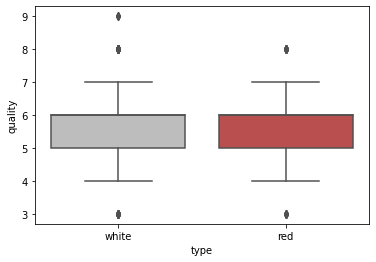

In [17]:
# type별 quality(target:점수) 확인

# 색 지정
colors = ["#BDBDBD", "#CC3D3D"]
sns.set_palette(sns.color_palette(colors))

#시각화
sns.boxplot(data=full_df, x='type', y='quality');

`type`에 따라 `quality`가 큰 차이를 보이지는 않는다. (휴, 다행) 
 
이에 `type`구분 없이, 전체 데이터에서 `quality`를 구분하려 한다.

In [18]:
# 타겟 정보 확인
full_df['quality'].describe()

count    5329.000000
mean        5.796022
std         0.879922
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

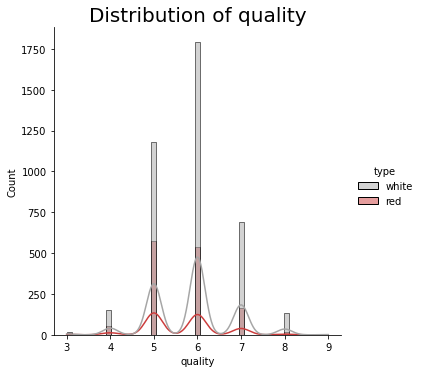

In [19]:
# 타겟 분포 확인

# 색 지정
colors = ["#A6A6A6", "#CC3D3D"]
sns.set_palette(sns.color_palette(colors))

#시각화
sns.displot(data=full_df, x='quality', hue='type', kde=True);
plt.title("Distribution of quality", y = 1.05, size = 20);

`와인을 점수에 따라 추천 한다/안한다`의 model이므로, 분류문제로 접근하려 한다  
`quality`가 6점 이상일 경우, 추천 O.
이하일 경우, 추천 X

In [20]:
# 6점 이상일 경우, True가 나오게 하는 칼럼 추가
full_df['recommend'] = full_df['quality'] >= 6

# 타겟 비율 확인
full_df['recommend'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


True     3338
False    1991
Name: recommend, dtype: int64

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


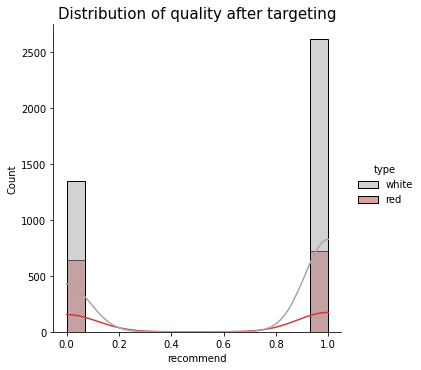

In [21]:
# 타겟 분류 이후의 분포 확인

# 색 지정
colors = ["#A6A6A6", "#CC3D3D"]
sns.set_palette(sns.color_palette(colors))

#시각화
sns.displot(data=full_df, x='recommend', hue='type', kde=True);
plt.title("Distribution of quality after targeting", y = 1.05, size = 15);

타겟을 분류한 이후, PCA를 통한 확인을 진행하려 한다

In [22]:
# 데이터에서 숫자로 된 부분만 따로 저장
df_num = full_df.iloc[:, 1:-2]

# Feature마다 scale이 다르기 때문에 StandardScaler를 적용
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 
df_num = StandardScaler().fit_transform(df_num) # 객체에 표준화한 데이터를 저장

# PCA 데이터 생성
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipal_Components = pca.fit_transform(df_num)

# 주성분으로 이루어진 데이터 프레임 구성
df_pca = pd.DataFrame(data=printcipal_Components, columns = ['PC1', 'PC2'])

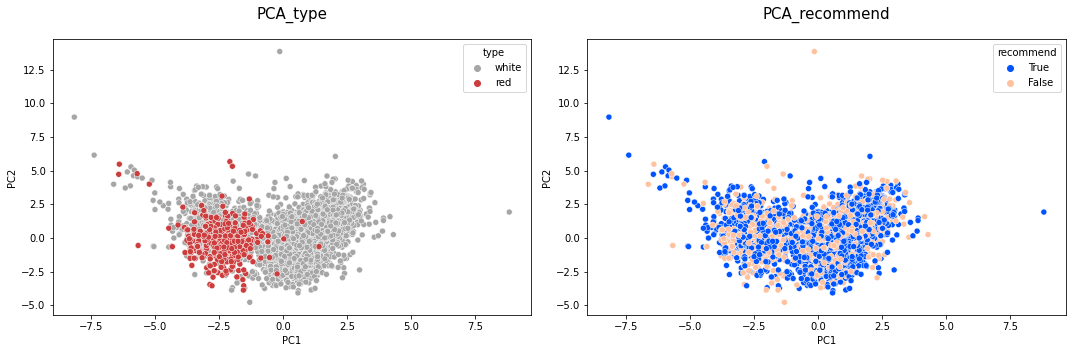

In [23]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))

# 시각화 _type
# 색 지정
colors1 = ["#A6A6A6", "#CC3D3D"]
sns.scatterplot(
    data = df_pca, 
    x = 'PC1', 
    y = 'PC2', 
    hue = full_df['type'],
    ax=axes[0],
    palette=colors1  
    );

# 시각화 _recommend
# 색 지정
colors2 = ["#0054FF", "#FFC19E"]

sns.scatterplot(
    data = df_pca, 
    x = 'PC1', 
    y = 'PC2', 
    hue = full_df['recommend'],
    ax=axes[1],
    palette=colors2 
    );

axes[0].set_title("PCA_type", y = 1.05, size = 15)
axes[1].set_title("PCA_recommend", y = 1.05, size = 15)

plt.tight_layout();

PCA 결과, `type`에 따른 성분 분석은 유효해 보이지만,  
 `recommend(추천 유무)`는 분석이 혼재되어 나타난다.

다시 말하자면, 굳이 `type`에 따라 `recommend(추천 유무)`를 구분할 필요가 없다는 것이다.

### **2-2. Features**

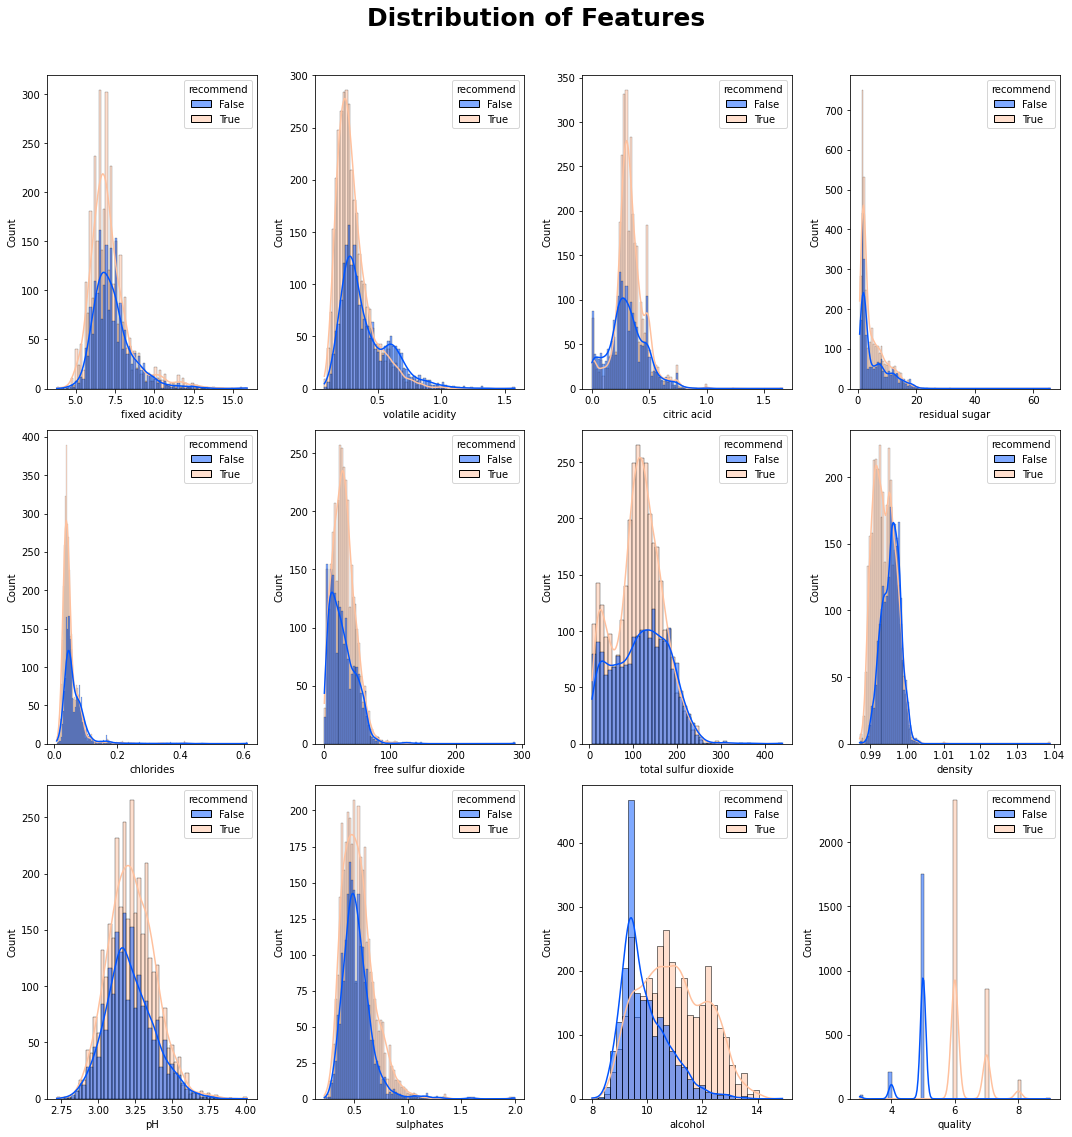

In [24]:
f, axes = plt.subplots(3, 4, figsize=(15, 15))

# 색 지정
colors = ["#0054FF", "#FFC19E"]
sns.set_palette(sns.color_palette(colors))

#시각화
sns.histplot(data=full_df, x='fixed acidity', hue='recommend', kde=True, ax=axes[0, 0]);
sns.histplot(data=full_df, x='volatile acidity', hue='recommend', kde=True, ax=axes[0, 1]);
sns.histplot(data=full_df, x='citric acid', hue='recommend', kde=True, ax=axes[0, 2]);
sns.histplot(data=full_df, x='residual sugar', hue='recommend', kde=True, ax=axes[0,3]);
sns.histplot(data=full_df, x='chlorides', hue='recommend', kde=True, ax=axes[1,0]);
sns.histplot(data=full_df, x='free sulfur dioxide', hue='recommend', kde=True, ax=axes[1,1]);
sns.histplot(data=full_df, x='total sulfur dioxide', hue='recommend', kde=True, ax=axes[1,2]);
sns.histplot(data=full_df, x='density', hue='recommend', kde=True, ax=axes[1,3]);
sns.histplot(data=full_df, x='pH', hue='recommend', kde=True, ax=axes[2,0]);
sns.histplot(data=full_df, x='sulphates', hue='recommend', kde=True, ax=axes[2,1]);
sns.histplot(data=full_df, x='alcohol', hue='recommend', kde=True, ax=axes[2,2]);
sns.histplot(data=full_df, x='quality', hue='recommend', kde=True, ax=axes[2,3]);

plt.suptitle('Distribution of Features',fontweight ="bold",y = 1.05, size = 25)
plt.tight_layout();

`pH` feature를 제외하고는 한 쪽으로 치우쳐 있음을 확인할 수 있다.  
이러한 비대칭 분포를 해결하기 위해, 로그변환을 하자!

In [25]:
features = list(full_df)[1:-1]
features.remove('pH')
features.remove('quality')
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'sulphates',
 'alcohol']

In [26]:
# 로그변환
import numpy as np

for a in features:
     full_df[a] = np.log1p(full_df[a])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


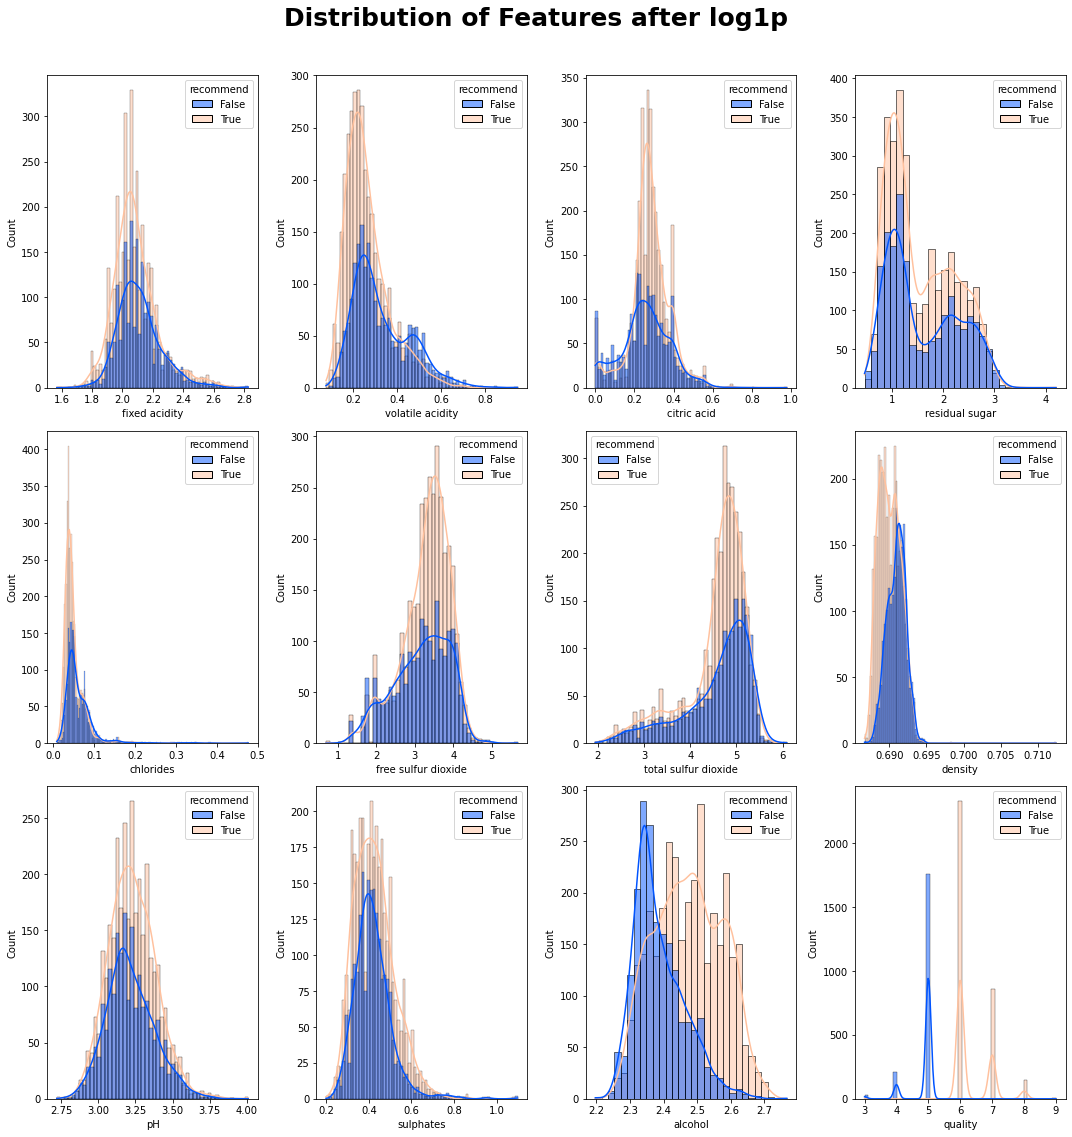

In [27]:
# 다시 확인
f, axes = plt.subplots(3, 4, figsize=(15, 15))

# 색 지정
colors = ["#0054FF", "#FFC19E"]
sns.set_palette(sns.color_palette(colors))

#시각화
sns.histplot(data=full_df, x='fixed acidity', hue='recommend', kde=True, ax=axes[0, 0]);
sns.histplot(data=full_df, x='volatile acidity', hue='recommend', kde=True, ax=axes[0, 1]);
sns.histplot(data=full_df, x='citric acid', hue='recommend', kde=True, ax=axes[0, 2]);
sns.histplot(data=full_df, x='residual sugar', hue='recommend', kde=True, ax=axes[0,3]);
sns.histplot(data=full_df, x='chlorides', hue='recommend', kde=True, ax=axes[1,0]);
sns.histplot(data=full_df, x='free sulfur dioxide', hue='recommend', kde=True, ax=axes[1,1]);
sns.histplot(data=full_df, x='total sulfur dioxide', hue='recommend', kde=True, ax=axes[1,2]);
sns.histplot(data=full_df, x='density', hue='recommend', kde=True, ax=axes[1,3]);
sns.histplot(data=full_df, x='pH', hue='recommend', kde=True, ax=axes[2,0]);
sns.histplot(data=full_df, x='sulphates', hue='recommend', kde=True, ax=axes[2,1]);
sns.histplot(data=full_df, x='alcohol', hue='recommend', kde=True, ax=axes[2,2]);
sns.histplot(data=full_df, x='quality', hue='recommend', kde=True, ax=axes[2,3]);

plt.suptitle('Distribution of Features after log1p',fontweight ="bold",y = 1.05, size = 25)
plt.tight_layout()

## **Step 3. Feature Engineering**

In [28]:
df = full_df.copy()
def f_e(df):
    # sugar_acidity_ratio 컬럼 추가
    df['sugar acidity ratio'] = df['residual sugar'] / df['fixed acidity']

    # free_total_ulfur_dioxid_rate 컬럼 추가
    df['free total ulfur dioxid rate'] = df['free sulfur dioxide'] / df['total sulfur dioxide']

    # bound_sulfur_dioxid 컬럼 추가
    df['bounded sulfur dioxid'] = df['total sulfur dioxide'] - df['free sulfur dioxide']

    return (df)

full_df = f_e(full_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [29]:
full_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,recommend,sugar acidity ratio,free total ulfur dioxid rate,bounded sulfur dioxid
0,white,2.079442,0.239017,0.307485,3.077312,0.044017,3.828641,5.141664,0.693647,3.00,0.371564,2.282382,6,True,1.479874,0.744631,1.313022
1,white,1.987874,0.262364,0.292670,0.955511,0.047837,2.708050,4.890349,0.690143,3.30,0.398776,2.351375,6,True,0.480670,0.553754,2.182299
2,white,2.208274,0.246860,0.336472,2.066863,0.048790,3.433987,4.584967,0.690694,3.26,0.364643,2.406945,6,True,0.935963,0.748967,1.150980
3,white,2.104134,0.207014,0.277632,2.251292,0.056380,3.871201,5.231109,0.690945,3.19,0.336472,2.388763,6,True,1.069937,0.740035,1.359908
6,white,1.974081,0.277632,0.148420,2.079442,0.044017,3.433987,4.919981,0.690594,3.18,0.385262,2.360854,6,True,1.053372,0.697968,1.485994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,2.054124,0.482426,0.076961,1.064711,0.065788,3.367296,3.663562,0.691401,3.42,0.598837,2.351375,6,True,0.518328,0.919132,0.296266
6492,red,1.974081,0.470004,0.076961,1.098612,0.086178,3.496508,3.806662,0.690594,3.45,0.457425,2.442347,5,False,0.556518,0.918523,0.310155
6493,red,1.931521,0.438255,0.095310,1.163151,0.060154,3.688879,3.951244,0.690704,3.52,0.482426,2.501436,6,True,0.602194,0.933600,0.262364
6495,red,1.931521,0.497740,0.113329,1.098612,0.072321,3.496508,3.806662,0.690880,3.57,0.536493,2.415914,5,False,0.568781,0.918523,0.310155


## **Step 4. Modeling**

### **4-1. Target 및 데이터 셋 설정**

In [30]:
# 타겟 설정
target = 'recommend'
features = full_df.columns.drop([target, 'quality'])

In [31]:
# 훈련/검증/테스트 세트 분리
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_df, test_size=0.20, 
                              stratify=full_df[target], random_state=2)
train, val = train_test_split(train, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((3410, 17), (853, 17), (1066, 17))

In [32]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [33]:
# 타겟 비율 확인
train[target].value_counts(normalize=True)  ## 비대칭 -> 차후 불균형 클래스 보완 필요

True     0.626393
False    0.373607
Name: recommend, dtype: float64

In [34]:
# 기준모델의 정확도 계산
from sklearn.metrics import accuracy_score
major = full_df[target].mode().loc[0]

y_pred = [major] * len(full_df[target])
print("baseline accuracy score : ", accuracy_score(full_df[target], y_pred))

baseline accuracy score :  0.6263839369487709


### **4-2. Modeling**

#### **4-2-1. Logistic Regression**

##### **1) model 학습**

In [35]:
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

pipe_lr = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(), # 특성값 평준화
    LogisticRegression(n_jobs=-1, random_state=10, class_weight='balanced')
)

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_val)
print('훈련세트 정확도 : ', pipe_lr.score(X_train, y_train))
print('검증세트 정확도 : ', pipe_lr.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


훈련세트 정확도 :  0.7448680351906158
검증세트 정확도 :  0.7561547479484173
-----------------------------------------------------------
검증세트 F1-score :  0.7898989898989899


기준모델 보다도 높은 정확도를 보이며, 모델이 얼마나 효과적인지를 보여주는 `f1-score`역시 나쁘지 않다.

##### **2) model 평가**

**Confusion Matrix**

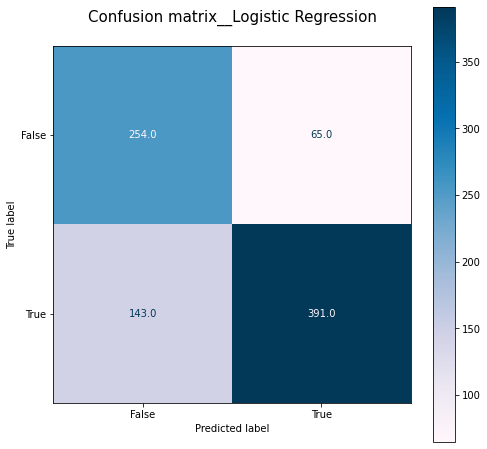

In [36]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 8))

pcm = plot_confusion_matrix(pipe_lr, X_val, y_val,
                            cmap='PuBu',
                            ax=ax, values_format =".1f");

plt.title(f'Confusion matrix__Logistic Regression', y = 1.05, fontsize=15)
plt.show()

In [37]:
from sklearn.metrics import classification_report

y_pred = pipe_lr.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.64      0.80      0.71       319
        True       0.86      0.73      0.79       534

    accuracy                           0.76       853
   macro avg       0.75      0.76      0.75       853
weighted avg       0.78      0.76      0.76       853



해당 모델은 `와인의 점수를 예측하는 모델`이기 때문에 **정밀도(Precision)**,  
즉 **참이라고 예측한 것 중, 실제로도 참인 비율**이 높아야 한다.

이를 분류모델의 성능을 시각화 한, `Confusion Matrix`를 통해 살펴보려 한다.  
만약 모델이 완벽하게 예측했다면 대각선(`\`)방향의 색이 짙어야 한다.  

해당 모델은 **참이라 예측한 것 중, 실제로도 참인 비율**이 `0.86`으로, 재현율(Recall)보다 더 높다.

**ROC curve, AUC**

AUC score : 0.764223991170911


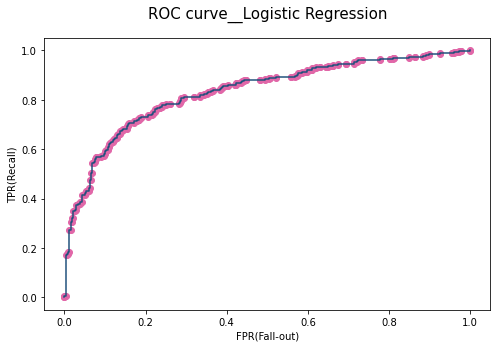

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

proba_lr = pipe_lr.predict_proba(X_val)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_val, proba_lr)

# 시각화
plt.figure(figsize=(8, 5))

plt.plot(fpr_lr, tpr_lr, color='#1F507C')
plt.scatter(fpr_lr, tpr_lr, color='#E167A8')

plt.title('ROC curve__Logistic Regression', y = 1.05, fontsize=15)
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_lr = roc_auc_score(y_val, y_pred)
print(f'AUC score : {auc_score_lr}')

이를 한 눈에 살펴보기 위해 `ROC curve`를 그려보았다.  
여기서 `AUC score`는 곡선 아래의 면적값을 의미하는데,  
참/거짓에 대한 예측을 실제와 잘 일치시켜 안정된 예측을 할 수 있는 모델일수록 `AUC score`가 높다.

##### **3) Hyperparam Tuning**

In [39]:
from sklearn.model_selection import GridSearchCV

param_lr = {
    'logisticregression__penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'logisticregression__class_weight': ['balanced'],
    'logisticregression__C': [1.0, 0.9, 0.8],
    'logisticregression__max_iter': [300],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__l1_ratio': [1.0, 0.0, 0.3],
}

clf_lr = GridSearchCV(
   estimator=pipe_lr,
   scoring='balanced_accuracy',
   param_grid=param_lr,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

clf_lr.fit(X_train, y_train);

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   28.4s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [40]:
# 튜닝된 파라미터 확인
print('튜닝된 파라미터 : ', clf_lr.best_params_)

# 최고 정확도
print('하이퍼파라미터 튜닝 이후 최고 정확도 : ', clf_lr.best_score_)

튜닝된 파라미터 :  {'logisticregression__C': 1.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__l1_ratio': 1.0, 'logisticregression__max_iter': 300, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
하이퍼파라미터 튜닝 이후 최고 정확도 :  0.7419823648924082


In [41]:
# 최적의 하이퍼파라미터를 적용, 모델의 예측 정확도(accuracy score) 확인

pipe_lr2 = clf_lr.best_estimator_

pipe_lr2.fit(X_train, y_train)

y_train_pred = pipe_lr2.predict(X_train)
y_val_pred = pipe_lr2.predict(X_val)

print('훈련 정확도 : ', pipe_lr2.score(X_train, y_train))
print('검증 정확도 : ', pipe_lr2.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_val_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


훈련 정확도 :  0.7445747800586511
검증 정확도 :  0.7561547479484173
-----------------------------------------------------------
검증세트 F1-score :  0.7898989898989899


#### **4-2-2. Decision Tree**

##### **1) model 학습**

In [42]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(), # 특성값 평준화
    DecisionTreeClassifier(criterion='entropy', random_state=10, class_weight='balanced', max_depth=10)
)

pipe_dt.fit(X_train, y_train)

y_pred = pipe_dt.predict(X_val)
print('훈련세트 정확도 : ', pipe_dt.score(X_train, y_train))
print('검증세트 정확도 : ', pipe_dt.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_pred))

훈련세트 정확도 :  0.8510263929618769
검증세트 정확도 :  0.6776084407971864
-----------------------------------------------------------
검증세트 F1-score :  0.7150259067357512


훈련세트의 정확도는 높지만 검증세트는 낮은 것으로 보아, 과적합했다는 것을 알 수 있다.  

##### **2) model 평가**

**Confusion Matrix**

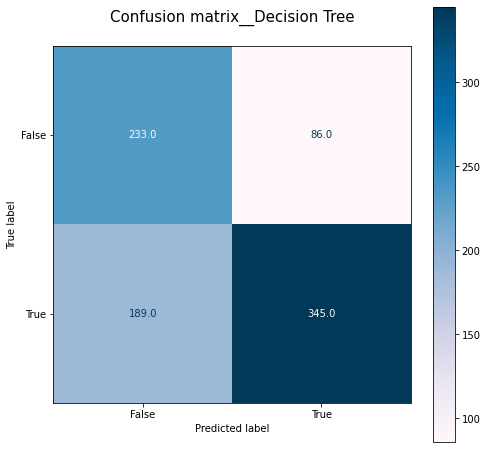

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))

pcm = plot_confusion_matrix(pipe_dt, X_val, y_val,
                            cmap='PuBu',
                            ax=ax, values_format =".1f");

plt.title(f'Confusion matrix__Decision Tree', y = 1.05, fontsize=15)
plt.show()

In [44]:
y_pred = pipe_dt.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.55      0.73      0.63       319
        True       0.80      0.65      0.72       534

    accuracy                           0.68       853
   macro avg       0.68      0.69      0.67       853
weighted avg       0.71      0.68      0.68       853



정밀도가 `0.80`으로 `Logistic Regression` 모델보다 낮다.


**ROC curve, AUC**

AUC score : 0.6882374696206545


<Figure size 576x360 with 0 Axes>

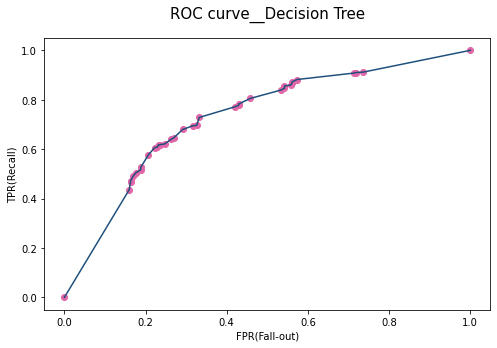

In [45]:
proba_dt = pipe_dt.predict_proba(X_val)[:, 1]

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, proba_dt)

plt.figure(figsize=(8, 5))

# 시각화
plt.figure(figsize=(8, 5))

plt.plot(fpr_dt, tpr_dt, color='#1F507C');
plt.scatter(fpr_dt, tpr_dt, color='#E167A8');

plt.title('ROC curve__Decision Tree', y = 1.05, fontsize=15)
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_dt = roc_auc_score(y_val, y_pred)
print(f'AUC score : {auc_score_dt}')

`AUC score` 역시 `Logistic Regression` 모델보다 더 낮다..

##### **3) Hyperparam Tuning**

In [46]:
param_dt = {
    'decisiontreeclassifier__criterion': ['entrophy', 'gini'],
    'decisiontreeclassifier__max_depth': np.arange(1, 10),
    'decisiontreeclassifier__max_leaf_nodes': np.arange(1, 30, 5),
    'decisiontreeclassifier__min_samples_leaf': np.arange(10, 50, 5)
}

clf_dt = GridSearchCV(
   estimator=pipe_dt,
   scoring='balanced_accuracy',
   param_grid=param_dt,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

clf_dt.fit(X_train, y_train);

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 3896 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   33.3s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [47]:
# 튜닝된 파라미터 확인
print('튜닝된 파라미터 : ', clf_dt.best_params_)

# 최고 정확도
print('하이퍼파라미터 튜닝 이후 최고 정확도 : ', clf_dt.best_score_)

튜닝된 파라미터 :  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_leaf_nodes': 21, 'decisiontreeclassifier__min_samples_leaf': 45}
하이퍼파라미터 튜닝 이후 최고 정확도 :  0.7302036345518544


In [48]:
# 최적의 하이퍼파라미터를 적용, 모델의 예측 정확도(accuracy score) 확인

pipe_dt2 = clf_dt.best_estimator_

pipe_dt2.fit(X_train, y_train)

y_train_pred = pipe_dt2.predict(X_train)
y_val_pred = pipe_dt2.predict(X_val)

print('훈련 정확도 : ', pipe_dt2.score(X_train, y_train))
print('검증 정확도 : ', pipe_dt2.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_val_pred))

훈련 정확도 :  0.7316715542521994
검증 정확도 :  0.7139507620164126
-----------------------------------------------------------
검증세트 F1-score :  0.736501079913607


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


하이퍼파라미터 튜닝을 해도 `Logistic Regression`모델을 넘지 못했다.  
`Decision Tree` 이외의 다른 모델을 구상할 필요가 있다.

#### **4-3-3. Random Forest**

##### **1) model 학습**

In [49]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(), # 특성값 평준화
    RandomForestClassifier(criterion='entropy', random_state=10, n_jobs=-1, oob_score=True, max_depth=5, class_weight='balanced')
)

pipe_rf.fit(X_train, y_train)

y_pred = pipe_rf.predict(X_val)
print('훈련세트 정확도 : ', pipe_rf.score(X_train, y_train))
print('검증세트 정확도 : ', pipe_rf.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_pred))

훈련세트 정확도 :  0.7791788856304985
검증세트 정확도 :  0.7561547479484173
-----------------------------------------------------------
검증세트 F1-score :  0.7837837837837838


`Logistic Regression`모델과 비슷한 결과를 보인다.

##### **2) model 평가**

**Confusion Matrix**

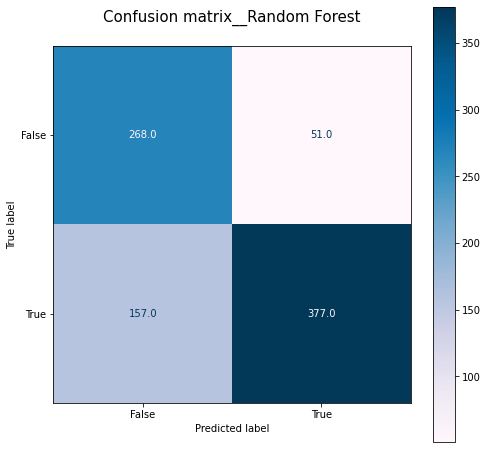

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))

pcm = plot_confusion_matrix(pipe_rf, X_val, y_val,
                            cmap='PuBu',
                            ax=ax, values_format =".1f");

plt.title(f'Confusion matrix__Random Forest', y = 1.05, fontsize=15)
plt.show()

In [51]:
y_pred = pipe_rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.63      0.84      0.72       319
        True       0.88      0.71      0.78       534

    accuracy                           0.76       853
   macro avg       0.76      0.77      0.75       853
weighted avg       0.79      0.76      0.76       853



정밀도가 `0.88`로, `Logistic Regression` 모델보다 더 높은 수치를 보인다.


**ROC curve, AUC**

AUC score : 0.7730589506064126


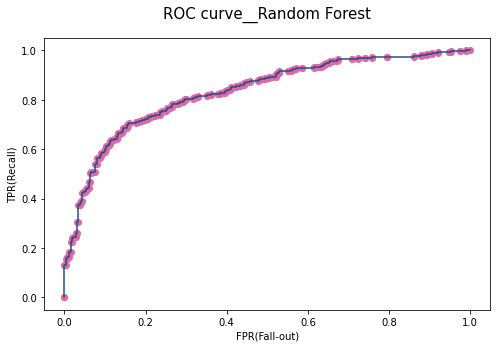

In [52]:
proba_rf = pipe_rf.predict_proba(X_val)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, proba_rf)

# 시각화
plt.figure(figsize=(8, 5))

plt.plot(fpr_rf, tpr_rf, color='#1F507C')
plt.scatter(fpr_rf, tpr_rf, color='#E167A8')

plt.title('ROC curve__Random Forest', y = 1.05, fontsize=15)
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_rf = roc_auc_score(y_val, y_pred)
print(f'AUC score : {auc_score_rf}')

`AUC score` 역시 `Logistic Regression` 모델보다 더 높은 수치이다.

##### **3) Hyperparam Tuning**

In [53]:
param_rf = {
    'randomforestclassifier__criterion': ['entrophy', 'gini'],
    'randomforestclassifier__max_depth': np.arange(1, 10),
    'randomforestclassifier__max_leaf_nodes': np.arange(1, 60, 5),
    'randomforestclassifier__min_samples_leaf': np.arange(10, 25, 5)
    
}

clf_rf = GridSearchCV(
   estimator=pipe_rf,
   scoring='balanced_accuracy',
   param_grid=param_rf,
   cv=3,
   n_jobs=-1, 
   verbose=3
)

clf_rf.fit(X_train, y_train);

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  3.4min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [54]:
# 튜닝된 파라미터 확인
print('튜닝된 파라미터 : ', clf_rf.best_params_)

# 최고 정확도
print('하이퍼파라미터 튜닝 이후 최고 정확도 : ', clf_rf.best_score_)

튜닝된 파라미터 :  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_leaf_nodes': 41, 'randomforestclassifier__min_samples_leaf': 10}
하이퍼파라미터 튜닝 이후 최고 정확도 :  0.7495077982433168


In [55]:
# 최적의 하이퍼파라미터를 적용, 모델의 예측 정확도(accuracy score) 확인

pipe_rf2 = clf_rf.best_estimator_

pipe_rf2.fit(X_train, y_train)

y_train_pred = pipe_rf2.predict(X_train)
y_val_pred = pipe_rf2.predict(X_val)

print('훈련 정확도 : ', pipe_rf2.score(X_train, y_train))
print('검증 정확도 : ', pipe_rf2.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_val_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 :  0.7950146627565983
검증 정확도 :  0.7631887456037515
-----------------------------------------------------------
검증세트 F1-score :  0.7947154471544716


현재까지는 `Random Forest`모델이 가장 적합해 보인다.

#### **4-3-4. Xgboost**

##### **1) model 학습**

In [56]:
from xgboost import XGBClassifier

pipe_xg = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(), # 특성값 평준화
    XGBClassifier(criterion='entropy', random_state=10, n_jobs=-1, oob_score=True, n_estimators=100, class_weight='balanced')
)

pipe_xg.fit(X_train, y_train)

y_pred = pipe_xg.predict(X_val)
print('훈련세트 정확도 : ', pipe_xg.score(X_train, y_train))
print('검증세트 정확도 : ', pipe_xg.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_pred))

훈련세트 정확도 :  0.8155425219941349
검증세트 정확도 :  0.753810082063306
-----------------------------------------------------------
검증세트 F1-score :  0.8066298342541436


벌써부터 `Random Forest`모델보다 좋은 성능을 보인다.

##### **2) model 평가**

**Confusion Matrix**

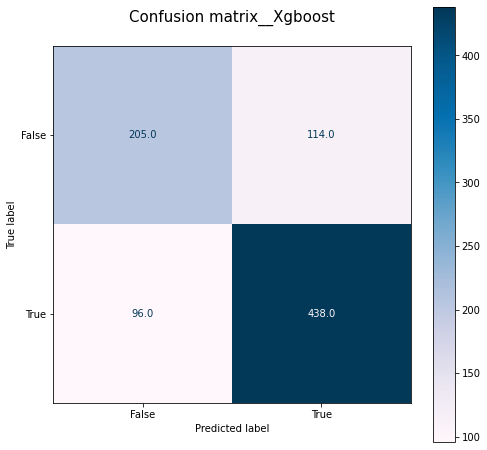

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))

pcm = plot_confusion_matrix(pipe_xg, X_val, y_val,
                            cmap='PuBu',
                            ax=ax, values_format =".1f");

plt.title(f'Confusion matrix__Xgboost', y = 1.05, fontsize=15)
plt.show()

In [58]:
y_pred = pipe_xg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.68      0.64      0.66       319
        True       0.79      0.82      0.81       534

    accuracy                           0.75       853
   macro avg       0.74      0.73      0.73       853
weighted avg       0.75      0.75      0.75       853



눈에 띄게 대각선(`\`)의 색이 짙어진 것을 확인할 수 있다.  
이는 모델이 높은 예측률을 보인다는 것이다.

하지만 `Random Forest`모델보다 **낮은 정밀도**를 보인다는 것에 주목할 만하다.

**ROC curve, AUC**

AUC score : 0.7314289739706246


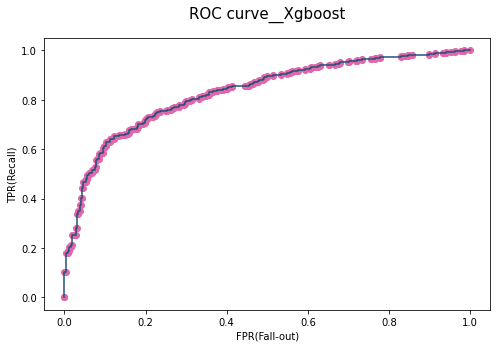

In [59]:
proba_xg = pipe_xg.predict_proba(X_val)[:, 1]

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_val, proba_xg)

# 시각화
plt.figure(figsize=(8, 5))

plt.plot(fpr_xg, tpr_xg, color='#1F507C')
plt.scatter(fpr_xg, tpr_xg, color='#E167A8')

plt.title('ROC curve__Xgboost', y = 1.05, fontsize=15)
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score_xg = roc_auc_score(y_val, y_pred)
print(f'AUC score : {auc_score_xg}')

`AUC score`가 `Random Forest`모델 보다 더 **낮아졌다.**  
이는 `Random Forest`모델이 `Xbgoost`모델보다 더 안정적인 예측은 한다는 것이다.

##### **3) Hyperparam Tuning**

In [60]:
param_xg = {
    'xgbclassifier__criterion': ['entrophy', 'gini'],
    'xgbclassifier__max_depth': np.arange(1, 10),
    'xgbclassifier__max_leaf_nodes': np.arange(1, 30, 5),
    'xgbclassifier__min_samples_leaf': np.arange(10, 30, 5)
    
}

clf_xg = GridSearchCV(
   estimator=pipe_xg,
   scoring='balanced_accuracy',
   param_grid=param_xg,
   cv=3,
   n_jobs=-1, 
   verbose=3
)

model = clf_xg.fit(X_train, y_train);

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  3.1min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [61]:
# 튜닝된 파라미터 확인
print('튜닝된 파라미터 : ', clf_xg.best_params_)

# 최고 정확도
print('하이퍼파라미터 튜닝 이후 최고 정확도 : ', clf_xg.best_score_)

튜닝된 파라미터 :  {'xgbclassifier__criterion': 'entrophy', 'xgbclassifier__max_depth': 3, 'xgbclassifier__max_leaf_nodes': 1, 'xgbclassifier__min_samples_leaf': 10}
하이퍼파라미터 튜닝 이후 최고 정확도 :  0.7367518404436186


In [62]:
# 최적의 하이퍼파라미터를 적용, 모델의 예측 정확도(accuracy score) 확인

pipe_xg2 = clf_xg.best_estimator_

pipe_xg2.fit(X_train, y_train)

y_train_pred = pipe_xg2.predict(X_train)
y_val_pred = pipe_xg2.predict(X_val)

print('훈련 정확도 : ', pipe_xg2.score(X_train, y_train))
print('검증 정확도 : ', pipe_xg2.score(X_val, y_val))
print('-----------------------------------------------------------')
print('검증세트 F1-score : ', f1_score(y_val, y_val_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 :  0.8155425219941349
검증 정확도 :  0.753810082063306
-----------------------------------------------------------
검증세트 F1-score :  0.8066298342541436


`Xgboost`모델의 `F1-score`가 **0.80이상**을 기록하면서 가장 높은 수치를 보였다.  
하지만 `와인 점수를 예측하는 모델`에서 중요한 **정밀도와 AUC score**가  `Random Forest`모델보다 낮으므로,  

**`Random Forest`모델을 채택하고자 한다.**

### **4-3. Test 데이터 셋**

In [63]:
# test data
pipe_rf2.fit(X_test, y_test)

y_test_pred = pipe_rf2.predict(X_test)

print('테스트 정확도 : ', pipe_rf2.score(X_test, y_test))
print('-----------------------------------------------------------')
print('테스트 셋 F1-score : ', f1_score(y_test, y_test_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


테스트 정확도 :  0.8367729831144465
-----------------------------------------------------------
테스트 셋 F1-score :  0.8649068322981366


In [64]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.75      0.84      0.79       398
        True       0.90      0.83      0.86       668

    accuracy                           0.84      1066
   macro avg       0.82      0.84      0.83      1066
weighted avg       0.84      0.84      0.84      1066



`0.90`이라는 높은 정밀도를 확인할 수 있다.

## **Step 5. Interpreting ML Model**

In [65]:
# final model

processor = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=8,
                                        max_features='auto', max_leaf_nodes=41,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=True, random_state=10,
                                        verbose=0, warm_start=False)
model.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=41, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

### **5-1. Feature Importance**

In [66]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, # model
    scoring='balanced_accuracy',
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [67]:
# permuter 계산은 preprocessing 된 X_val을 사용합니다.

X_val_transformed = processor.transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [68]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

residual sugar                  0.000057
fixed acidity                   0.002931
free sulfur dioxide             0.003070
type                            0.003432
sugar acidity ratio             0.004633
pH                              0.005813
bounded sulfur dioxid           0.007585
chlorides                       0.007760
citric acid                     0.008199
free total ulfur dioxid rate    0.009087
sulphates                       0.011366
total sulfur dioxide            0.011562
density                         0.014750
volatile acidity                0.051230
alcohol                         0.110047
dtype: float64

In [69]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1100 ± 0.0206,alcohol
0.0512 ± 0.0250,volatile acidity
0.0147 ± 0.0077,density
0.0116 ± 0.0024,total sulfur dioxide
0.0114 ± 0.0144,sulphates
0.0091 ± 0.0150,free total ulfur dioxid rate
0.0082 ± 0.0164,citric acid
0.0078 ± 0.0079,chlorides
0.0076 ± 0.0089,bounded sulfur dioxid
0.0058 ± 0.0030,pH


와인의 도수가 와인점수를 높이는 데에 있어서 가장 큰 요인임을 확인할 수 있다.  
와인의 향과 관련이 깊은 volatile acidity(휘발산), 와인의 무게감을 의미하는 density(밀도)가 뒤를 따른다.

### **5-2. Shap을 통한 개별 예측 설명**

##### **1) sample _01**

In [70]:
row = X_test.iloc[[450]]
row

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,sugar acidity ratio,free total ulfur dioxid rate,bounded sulfur dioxid
3835,white,1.974081,0.270027,0.207014,1.458615,0.050693,3.555348,4.736198,0.690288,3.16,0.392042,2.24071,0.738883,0.750675,1.18085


In [71]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

Feature 중요도에서 확인 했듯이, `alcohol`요인이 와인 점수에 가장 큰 영향을 미쳤다.

##### **2) sample _02**

In [72]:
row = X_test.iloc[[30]]
row

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,sugar acidity ratio,free total ulfur dioxid rate,bounded sulfur dioxid
1289,white,2.028148,0.14842,0.262364,0.955511,0.033435,2.772589,4.369448,0.689139,3.38,0.364643,2.501436,0.471125,0.63454,1.596859


In [73]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

하지만 점수를 주는 데에 있어서 `alcohol`이 항상 긍정적인 역할을 하는 것은 아니다.  
해당 예시에서는 더 높은 `alcohol`요소를 가졌지만, 부정적으로 작용함을 확인할 수 있다.

#**> Conclusion : 높은 정밀도를 나타내는 `Random Forest` 모델을 이용**
---



*   와인의 평가 점수를 예측하는 model을 통해,  
새로운 와인 데이터를 수집했을 때 **와인의 유통 여부**를 정할 수 있게 되었다.   

    또한 모델을 통해 얻을 수 있는 높은 점수의 와인을, **마케팅적으로도 활용**하는 방안을 기대해 볼 수 있을 것 같다.